# Age of mothers in the US from 1968 - 2018

### by Margarida Agrochao

Here I investigate how the distribution of age at which women give birth in the US has changed from 1968 to 2018. To answer this question I analysed natality data from the [National Bureau of Economic Research](http://data.nber.org/data/vital-statistics-natality-data.html)(NBER) in Python. The end goal is to plot the distribution of mothers' age, and the mean age for each year from 1968 to 2018.

### First, the modules

I'll start by importing the modules I used

In [2]:
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import re
import requests, zipfile, io
import random
import os
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Get links to data files

Here I use web scraping of the NBER website to find the links to the CSV natality data files. There's one file per year.

In [3]:
# Open URL

URL = 'http://data.nber.org/data/vital-statistics-natality-data.html'
req = Request(URL)
html_page = urlopen(req)

# Get contents of page

soup = BeautifulSoup(html_page, "lxml")

# Make list of all links in page

links = []
for link in soup.findAll('a'):
    links.append(link.get('href'))

# Remove noneType from list of links

links = [i or '' for i in links]

# Make list of links to CSV files

substring = 'http://data.nber.org/natality/.+.csv.zip'
csv_files = [i for i in links if re.search(substring, i)]

# For simplicity, exclude CSV with data from US territories

csv_files = [i for i in csv_files if re.match(r'^((?!natlterr).)*$', i)]

csv_files.sort()     

### Find the columns in the CSV files containing mothers' age data

The names of the columns in the CSV files containing mother's age data is not the same in every file. In 1968, for example, the mother age columns was named 'Age of Mother', and in 2018 'Mother's Single Years of Age'. The NBER website provides, along with the data, links to SAS code to read in the data. The code lists all the variables (labels) that are recorded in the CSV files, along with the corresponding column names (attrib), and length of the variable (length). Here's an example from [2018](http://data.nber.org/natality/2018/natl2018.sas).

attrib  mager &nbsp; &nbsp; &nbsp;length=3 &nbsp; &nbsp; &nbsp;label="Mother's Single Years of Age";

I scrapped the SAS code pages to find the attrib for each year that correspond to a label that contain the strings 'mother' and 'age'.

In [4]:
# Make list of years in data

years = []
for i in range(0, len(csv_files)):
    ext = csv_files[i].find('.csv.zip')
    years.append(csv_files[i][ext - 4:ext])

years.sort()

# Create directory to temporarily hold data file

if not os.path.exists('natality_data'):
    os.mkdir('natality_data')

# Make list of attribs     
    
mother_age_attribs = []

for i in range(0, len(years)):
    year = years[i]

    # Open URL
    
    URL = 'http://data.nber.org/natality/' + years[i] + '/natl' + years[
        i] + '.sas'
    req = Request(URL)
    html_page = urlopen(req)

    # Get contents of page
    
    soup = BeautifulSoup(html_page, 'lxml')

    # Turn parse tree into strings in separate lines 
    
    soup_pretty = soup.prettify()

    # Split string based on double space separator
    
    soup_split = soup_pretty.split('  ')

    # Remove trailing and leading spaces
    
    soup_strip = [i.strip() for i in soup_split]

    # Remove empty strings
    
    soup_no_empties = [i for i in soup_strip if i]

    # Remove "'s"
    
    soup_no_apostr = [i.replace("'s", "") for i in soup_no_empties]

    # Remove newline characters
    
    soup_no_newlines = [i.replace('\n', "") for i in soup_no_apostr]

    # Find the position of strings that include the substrings 'mother' and 'age'. Exclude the ones with substrings
    # 'recode', 'flag' and 'imputed'
    
    mother_age_label_idx = [
        i for i, x in enumerate(soup_no_newlines) if re.search(
            r'(?=.*Mother)(?=.*Age)(?!.*recode)(?!.*flag)(?!.*imputed).+$', x,
            re.IGNORECASE)
    ]

    # Finally, add the attrib corresponding to mother_age_label_idx to list
    
    mother_age_attribs.append(soup_no_newlines[mother_age_label_idx[0] - 2])

### Load mothers' age data

I randomly sampled 10000 data points from the millions available in each CSV file. The data from 2003 was discarded because every values in the mother's age column was 99, which, according to the documentation, indicates that the mother's age is not available.

In [5]:
# Create data frame to store age data

mother_age_df = pd.DataFrame()

# Size of sample to draw from CSV file

sample_size = 10000

for i in range(0, len(years)):

    # Download and extract CSV file
    
    r = requests.get(csv_files[i])
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall('natality_data')

    # Find number of rows in CSV file

    file = open('natality_data/' + listdir('natality_data')[0])
    nrows = sum(1 for i in file)

    # Make list of rows to skip when loading data
    
    to_skip = random.sample(range(1, nrows + 1), nrows - sample_size)
    to_skip.sort()

    # Read age data
    
    df = pd.read_csv('natality_data/' + listdir('natality_data')[0],
                     usecols=[mother_age_attribs[i]],
                     nrows=sample_size,
                     skiprows=to_skip)
    
    # Add age data to data frame
    
    mother_age_df[years[i]] = df[mother_age_attribs[i]]

    # Delete CSV file    
    
    os.remove('natality_data/' + listdir('natality_data')[0])
    
    print(years[i]+' done!')

# Delete data from 2003    
    
mother_age_df = mother_age_df.replace(99, np.nan)
mother_age_df = mother_age_df.dropna(axis=1, how='all')

1968 done!
1969 done!
1970 done!
1971 done!
1972 done!
1973 done!
1974 done!
1975 done!
1976 done!
1977 done!
1978 done!
1979 done!
1980 done!
1981 done!
1982 done!
1983 done!
1984 done!
1985 done!
1986 done!
1987 done!
1988 done!
1989 done!
1990 done!
1991 done!
1992 done!
1993 done!
1994 done!
1995 done!
1996 done!
1997 done!
1998 done!
1999 done!
2000 done!
2001 done!
2002 done!
2003 done!
2004 done!
2005 done!
2006 done!
2007 done!
2008 done!
2009 done!
2010 done!
2011 done!
2012 done!
2013 done!
2014 done!
2015 done!
2016 done!
2017 done!
2018 done!


### Visualize distribution of the data per year

Let's look at the distribution of ages for each year. Violin plots provide a compact way of displaying the whole distribution. 

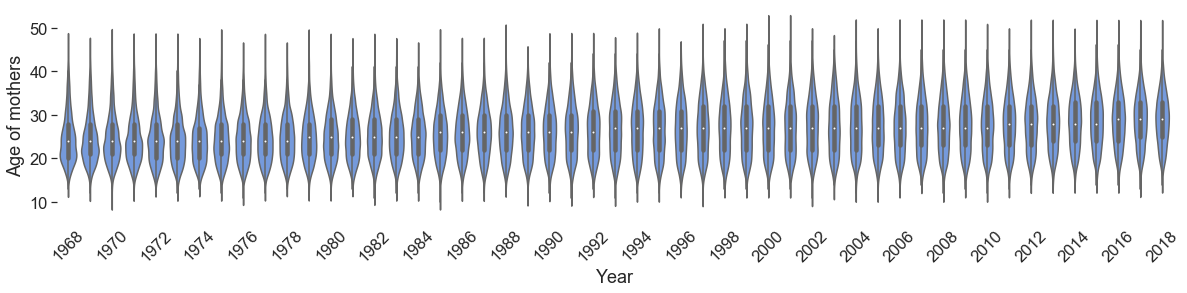

In [28]:
sns.set(font_scale=1.5)
sns.set_style("ticks")

fig, ax = plt.subplots(1, 1, figsize=[20, 4])
sns.violinplot(data=mother_age_df, color='cornflowerblue', linewidth=1.5)
sns.despine(bottom=True, left=True)
plt.ylim(5, 55)
plt.xticks(rotation=45)
ax.xaxis.set_tick_params(length=0)
plt.xlabel('Year')
plt.ylabel('Age of mothers')

# Make x-axis less crowded

for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % 2 != 0:
        label.set_visible(False)



Looking at the distributions above, it seems that there is not only variation of the mean age, but also in the dispersion of the data. Below I plot those two quantities explicitly: the mean of the data and the dispersion as measured by the standard deviation.

### Visualize mean and standard deviation of data per year

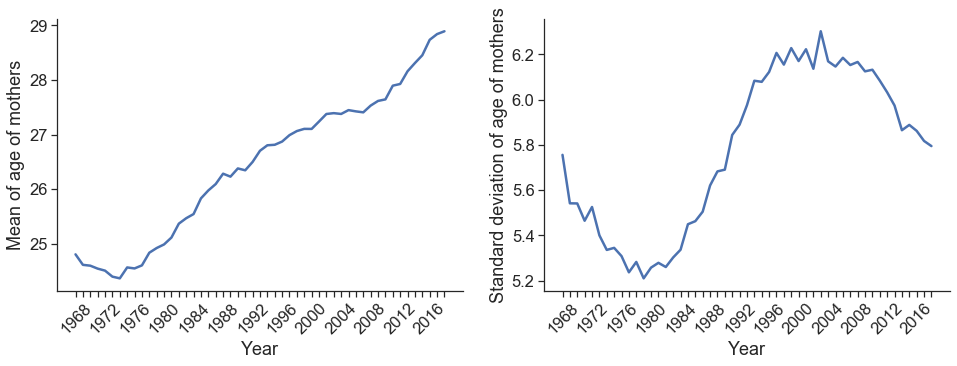

In [93]:
sns.set(font_scale=1.5)
sns.set_style("ticks")

# Mean

fig, ax = plt.subplots(1, 2, figsize=[16, 5])
sns.lineplot(data=mother_age_df.mean(),ax=ax[0],linewidth=2.5)
sns.despine(top=True, right=True)
ax[0].set_xticklabels (labels=years,Rotation=45)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Mean of age of mothers')

# Standard deviation

sns.lineplot(data=mother_age_df.std(),ax=ax[1],linewidth=2.5)
sns.despine(top=True, right=True)
ax[1].set_xticklabels (labels=years,Rotation=45)
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Standard deviation of age of mothers')

# Make x-axes less crowded

for index, label in enumerate(ax[0].xaxis.get_ticklabels()):
    if index %4 != 0:
        label.set_visible(False)
        
for index, label in enumerate(ax[1].xaxis.get_ticklabels()):
    if index % 4 != 0:
        label.set_visible(False)
        

Consistent with popular belief, the mean age at which mothers have children has been increasing in the decades. The standard deviation of the data is more complex, decreasing from the late sixties to the late seventies, then increasing until the early aughts, and decreasing back down.